# 분류기(Classifier) 학습하기  

## 1. 데이터 로딩  

pytorch는 특히 영상데이터를 위한 `torchvision` 패키지가 있음,   

- `torchvision.datasets`: ImageNet이나, CIFAR10, MNIST 같은 데이터셋들 제공  
- `torchvision.data.DataLoader`: 이미지용 데이터 변환기 (data transformer)  


여기서는 CIFAR10 이미지 데이터셋(비행기, 자동차, 새, 고양이 등)을 이용  
이미지 크기는 3x32x32로, 32x32 픽셀 크기에 RGB(3채널) 색상으로 이루어져 있다.  

또한, train data는 50,000장, test는 10,000장이 포함되어 있다.  

![png](image/cifar10.png){: .align-center}{: width="70%" height="70%"}  

torchvision 데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지인데, 이를 [-1, 1]의 범위로 정규화된 Tensor로 변환함  

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4  # 한 batch당 4장의 이미지가 들어감
down_dir = 'D:/pytorch-study/cifar10'
trainset = torchvision.datasets.CIFAR10(root=down_dir, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=down_dir, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


- 샘플 데이터 시각화  

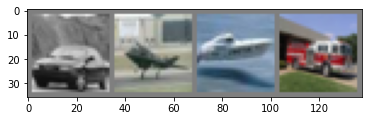

car   plane ship  truck


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

`iter`객체를 만들어 `next()`를 이용해 4장의 이미지가 출력되었는데, 이는 `batch_size`를 4로 설정했기 때문이다.  
`DataLoader`의 자세한 사용방법도 알 필요가 있다.  

In [13]:
print(images.shape)
print(labels.shape)

torch.Size([4, 3, 32, 32])
torch.Size([4])


# 2. 이미지 분류기 학습하기    

## 2.1 합성곱 신경망  

일반적인 `nn.conv2d`와 fully connected layer로 구성된 network를 생성한다.  
신경망 구성시 특히 CNN에서는 input과 output shape을 고려해서 layer를 쌓아야 한다.  

크게 주의할 점은 아래와 같다.  
- 맨 처음 layer(`self.conv1`)의 `in_channels`를 input image의 차원(RGB색상으로 3) 동일  
- layer 간  `in_channels`과 `out_channels` 차원 동일  
- fully connected layer(`self.fc1`)로 전환 시 flatten되는 채널 수 동일  

In [20]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # [4,3,32,32] -> [4,6,28,28]
        # [4,6,28,28] -> [4,6,14,14] pooling
        self.conv1 = nn.Conv2d(3, 6, 5) # input channel(3)에 맞춰주기
        self.pool = nn.MaxPool2d(2, 2)
        # [4,6,14,14] -> [4,16,10,10]
        # [4,16,10,10] -> [4,16,5,5] pooling
        self.conv2 = nn.Conv2d(6, 16, 5)
        # [4,16*5*5] -> [4,120]
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # [4,120] -> [4,84]
        self.fc2 = nn.Linear(120, 84)
        # [4,84] -> [4,10]
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 2.2 Loss function과 Optimizer  

Loss function은 교차 엔트로피 손실(Cross-Entropy loss) 사용  
Optimizer는 모멘텀(momentum) 값을 갖는 SGD를 사용  

In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 2.3 신경망 학습  

이제 지금까지 구성한 데이터, 신경망, loss function, optimizer를 이용해서 반복문을 생성하고, 신경망을 학습하도록 하자.  

`zero_gra`는 이전에 설명한 것 처럼 매 loop마다 해주어야 한다.  
한번 `backward()`를 통해 gradient를 `.grad`인자에 저장하고, `step()`을 통해 가중치를 갱신해주면, 다시 초기화를 해주어야 다음 학습에 영향을 주지 않기 때문이다.  

In [24]:
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, start=0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.173
[1,  4000] loss: 1.810
[1,  6000] loss: 1.682
[1,  8000] loss: 1.593
[1, 10000] loss: 1.520
[1, 12000] loss: 1.466
[2,  2000] loss: 1.385
[2,  4000] loss: 1.372
[2,  6000] loss: 1.338
[2,  8000] loss: 1.325
[2, 10000] loss: 1.296
[2, 12000] loss: 1.286
Finished Training


`Dataloader`에서 `batch_size`를 4로 설정했기 때문에 50,000장의 이미지는 12,500개의 batch에 들어 있어서 mini-batch로 학습되는 과정이 출력된 것을 알 수 있다.  
이러한 전체 데이터셋 과정을 2번 반복(`epoch`)한다.  
  

이렇게 학습된 모델을 아래와 같이 저장할 수 있다.  

In [29]:
PATH = down_dir+'./cifar_net.pth'
torch.save(net.state_dict(), PATH)

## 2.4 학습된 신경망 테스트  

살짝 학습시켜본 신경망을 테스트해보기 위해 샘플데이터를 다시 불러온다.  

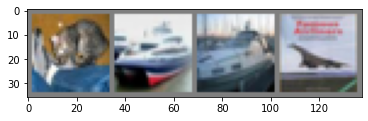

GroundTruth:  cat   ship  ship  plane


In [51]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

저장했던 모델을 다시 불러온다.  
여러가지 방법이 있지만 여기서는 기존에 `net.state_dict()`으로 모델을 저장했기 때문에, 다시 신경망 클래스에 `load_state_dict()`를 통해 저장된 파라미터 값들을 입혀주는 작업이다.  

In [54]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

이제 샘플 image를 신경망에 입력시켜주면, (4,10)차원의 값들이 출력된다.  
이는 4장의 이미지당 10개 class에 대한 분류 값을 의미한다.  

In [60]:
outputs = net(images)
print(outputs.shape)
print()
print(outputs)

torch.Size([4, 10])

tensor([[-1.2043, -2.9479,  1.4544,  2.3455, -0.4593,  2.0458,  0.6216, -0.2628,
         -0.3345, -1.3158],
        [ 3.8436,  3.9827, -1.2087, -2.5876, -2.5003, -3.7658, -3.0961, -3.4470,
          5.2269,  3.4458],
        [ 2.6759,  2.1911, -0.0536, -1.0604, -1.9619, -2.4842, -2.0110, -2.4893,
          3.3305,  1.6268],
        [ 3.3952,  0.1296,  0.8485, -1.5289,  0.4767, -2.9492, -2.2207, -2.4200,
          3.9059, -0.2636]], grad_fn=<AddmmBackward0>)


어떤 분류에 대해서 더 높은 값이 나타난다는 것은, 신경망이 그 이미지가 해당 분류에 더 가깝게 예측했다는 것을 의미한다.  
따라서 `torch.max(input,dim)`을 통해 최대값과 그에 해당하는 index를 뽑는다.  
신경망은 앞의 3개 이미지인 cat, ship, ship을 맞췄다!  

In [62]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


이제 전체 데이터셋에 대해 추론해보자.  
이 과정은 학습이 아니고 gradient를 계산할 필요가 없기 때문에 `torch.no_grad()`를 추가해준다.  

In [42]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


아래 코드는 각 class들 별로는 정확도가 어떻게 나오는지 다시 추론하는 과정이다.  

In [73]:
# 각 클래스에 대한 defalt dictionary 셋팅
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 48.8 %
Accuracy for class: car   is 60.5 %
Accuracy for class: bird  is 63.7 %
Accuracy for class: cat   is 32.9 %
Accuracy for class: deer  is 30.8 %
Accuracy for class: dog   is 30.5 %
Accuracy for class: frog  is 73.0 %
Accuracy for class: horse is 64.2 %
Accuracy for class: ship  is 73.0 %
Accuracy for class: truck is 63.0 %


# 3. GPU 활용  

Tensor를 GPU에 올렸던 것 처럼 신경망 자체도 GPU에 올릴 수 있다.  
일단 cuda device를 사용하도록 설정한다.  

In [74]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


그리고 아래와 같이 신경망의 설정을 변경해주면 된다.  

In [75]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

또한 아래와 같은 방법도 있다.  

In [76]:
net.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

그리고 매 루프마다 `DataLoader`에서 불러오는 input data와 label data 들도 아래와 같이 GPU에 올려 주어야 한다.  

In [78]:
inputs, labels = data[0].to(device), data[1].to(device)

In [85]:
print(inputs.device)
print(labels.device)

cuda:0
cuda:0


주의할 점은 위의 신경망처럼 바로 in-place 옵션이 적용이 안되고, GPU 적용 후 다시 객체에 넣어주어야한다.  